# OCR on forms

Forms have a defined structure.

Challenge: extract only information filled in by user.

In [1]:
# import the necessary packages
import numpy as np
import imutils
import cv2

from collections import namedtuple
import pytesseract

%matplotlib inline
import matplotlib.pyplot as plt

## The perfect template

A high resolution version of the empty form

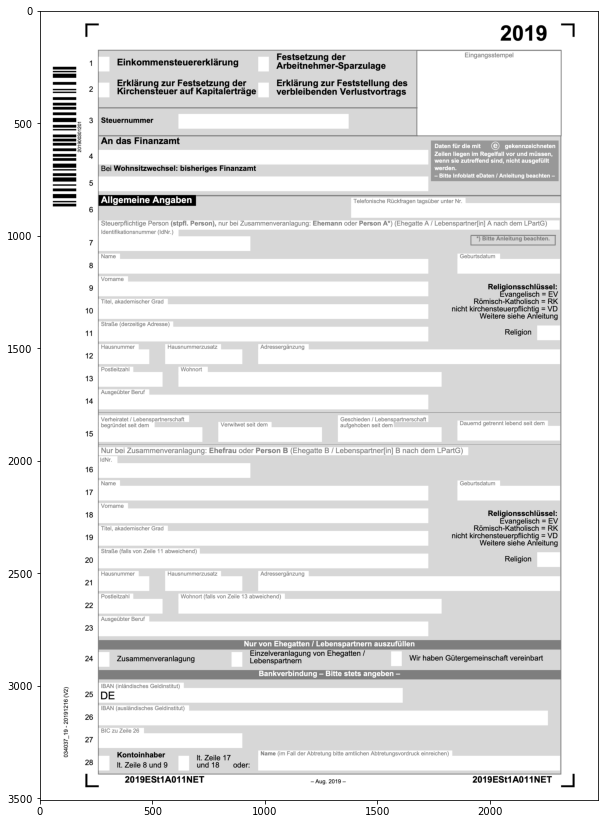

In [2]:
template_path = 'Scans/Steuer_Template.png'

template = cv2.imread(template_path)

figsize = (10, 20)

fig = plt.figure(figsize = figsize)

plt.imshow(template)

## The messy reality

A badly photographed partially filled-in form

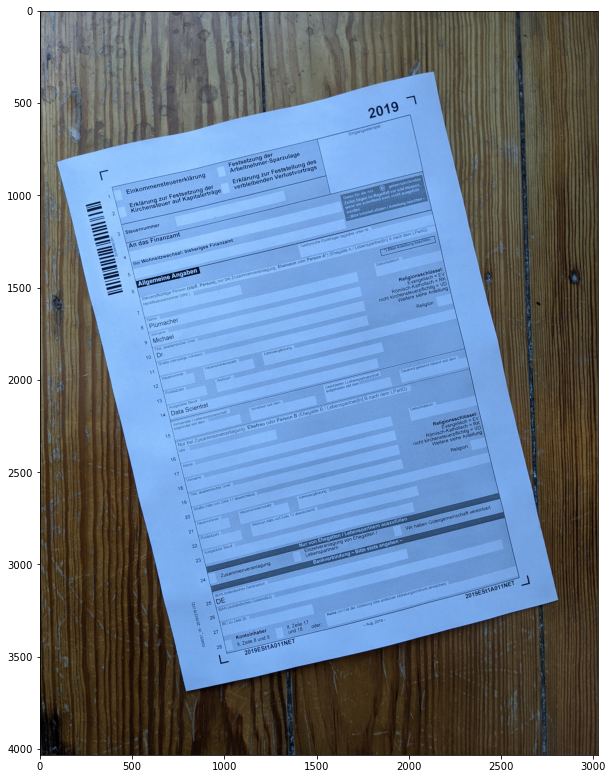

In [3]:
scan_path = 'Scans/Steuer_1.jpg'

scan = cv2.imread(scan_path)

scan = cv2.cvtColor(scan, cv2.COLOR_RGB2BGR)

fig = plt.figure(figsize = figsize)

plt.imshow(scan)

## Image alignment

Define a helper function to identify keypoints in the template. Those are then identified in the picture. Given enough keypoints and correspondences between the two we can compute the homography matrix to warp the image such that it corresponds to the template.

In [4]:
def align_images(image, template, maxFeatures=1000, keepPercent=0.2):
    # convert both the input image and template to grayscale
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    # use ORB to detect keypoints and extract (binary) local
    # invariant features
    orb = cv2.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)
    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)
    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x:x.distance)
    # keep only the top matches
    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]
    # visualize the keypoints
    matchedVis = cv2.drawMatches(image, kpsA, template, kpsB, matches, None, flags = 2|4)
    matchedVis = imutils.resize(matchedVis, width=1000)
    # allocate memory for the keypoints (x, y)-coordinates from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for (i, m) in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
    # compute the homography matrix between the two sets of matched
    # points
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    # use the homography matrix to align the images
    (h, w) = template.shape[:2]
    aligned = cv2.warpPerspective(imageGray, H, (w, h))
    # return the aligned image
    return aligned, matchedVis

What does the result of the alignment look like?

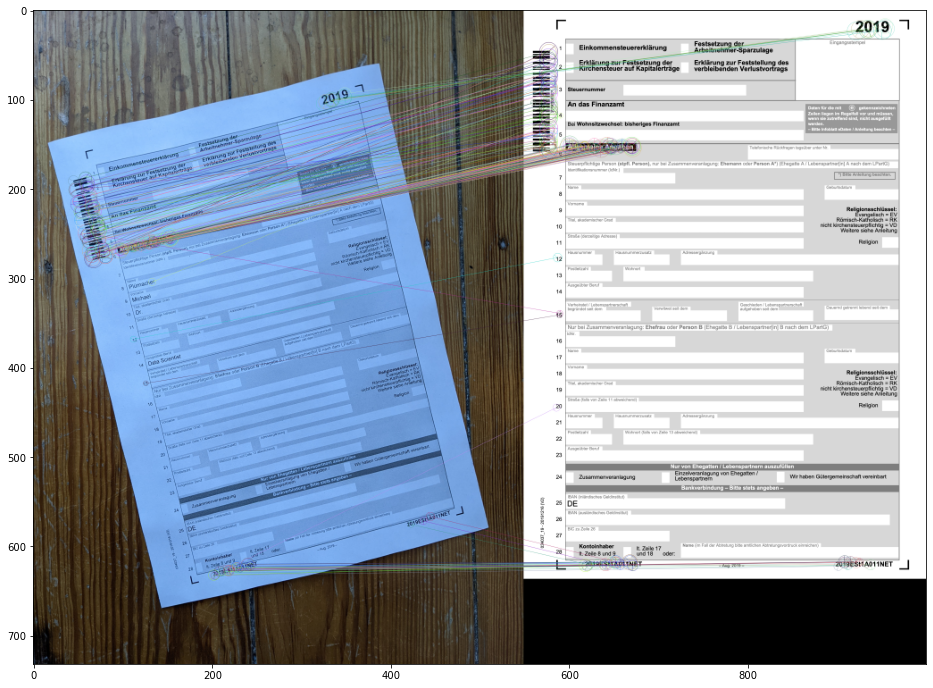

In [5]:
aligned, matchedVis = align_images(scan, template)

fig = plt.figure(figsize = (16, 30))

plt.imshow(matchedVis)

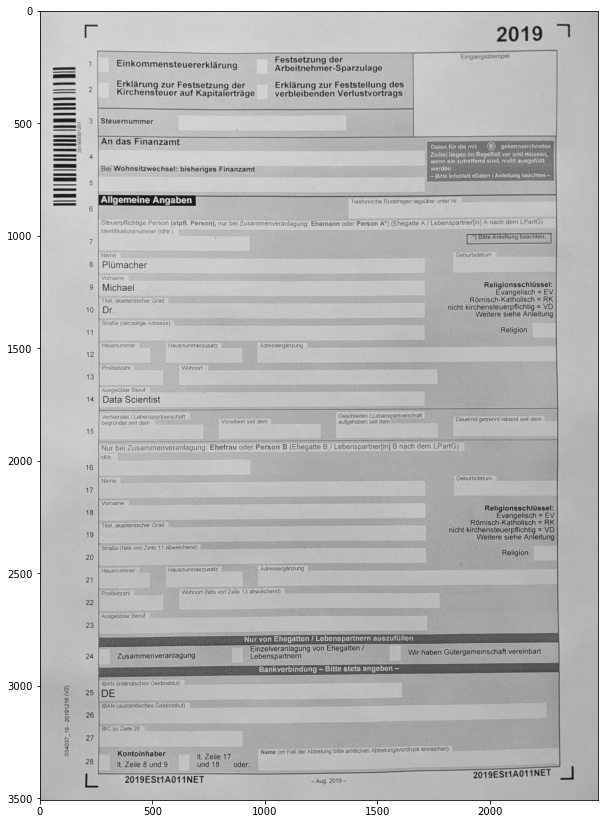

In [6]:
fig = plt.figure(figsize = figsize)

plt.imshow(cv2.cvtColor(aligned, cv2.COLOR_GRAY2BGR))

## Segmentation of individual fields in the form

In [7]:
# create a named tuple which we can use to create locations of the
# input document which we wish to OCR
OCRLocation = namedtuple("OCRLocation", ["id", "bbox", "filter_keywords"])

In [8]:
# define the locations of each area of the document we wish to OCR
OCR_LOCATIONS = [
    OCRLocation("step1_name", (264, 1106, 1460, 60),
        ["Name"]),
    OCRLocation("step1_first_name", (264, 1207, 1460, 60),
        ["Vorname"]),
    OCRLocation("step1_address", (264, 1710, 1460, 60),
        ["Ausgeübter", "Beruf"]),
]

## OCR each of the fields

In [9]:
parsingResults = []

# loop over the locations of the document we are going to OCR
for loc in OCR_LOCATIONS:
    # extract the OCR ROI from the aligned image
    (x, y, w, h) = loc.bbox
    roi = aligned[y:y + h, x:x + w]
    # OCR the ROI using Tesseract
    text = pytesseract.image_to_string(roi, lang='deu')
    # break the text into lines and loop over them
    for line in text.split("\n"):
        # if the line is empty, ignore it
        if len(line) == 0:
            continue
        # check to see if the
        # line contains any of the filter keywords (these keywords
        # are part of the *form itself* and should be ignored)
        count = sum([line.count(x) for x in loc.filter_keywords])
        # if the count is zero then we know we are *not* examining a
        # text field that is part of the document itself (ex., info,
        # on the field, an example, help text, etc.)
        if count == 0:
            # update our parsing results dictionary with the OCR'd
            # text if the line is *not* empty
            parsingResults.append((loc, line))

In [10]:
# what did tesseract find?

for i in range(0,3):
    print(parsingResults[i][1])


Plümacher
Michael
Data Scientist
